# This notebook computes the Gaussian and non-Gaussian signal-to-noise for primordial bispectra

In [1]:
import numpy as np
from PrimordialPowerspectrum import *
from PrimordialBispectra import *
from SecondaryPolyspectra import *
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
import vegas
from joblib import Parallel, delayed
%matplotlib inline

%config InlineBackend.figure_format = 'svg' 
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams.update({'font.size': 16})

In [2]:
print(h,As,ns)

0.6711 2.13e-09 0.9624


In [3]:
kF = 2.*np.pi / 1000.
kF

0.006283185307179587

In [4]:
kF * 360 / 2 * 2/3

0.7539822368615504

In [5]:
#these are the redshifts we consider
zs = [0,3,10,30,50,100]

#load the linear powerspectrum
PLindat = np.genfromtxt("PLinear.dat")
kPLin = PLindat[:,0]
PLindata = PLindat[:,1:]

In [6]:
#load the non-linear power spectrum as obtained from CAMB/HALOFIT
PNonLindat = np.genfromtxt("PHalo.dat")
kPNonLin = PNonLindat[:,0]
PNonLindata = PNonLindat[:,1:]

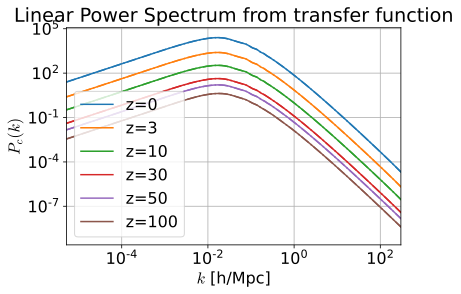

In [7]:
transfer_data = np.genfromtxt("LinearTransfer.dat")
kh_transfer = transfer_data[:,0]
Tc = transfer_data[:,1:]
k_transfer = kh_transfer*h
Pprim = P(k_transfer)

plt.loglog(kPLin,PLindata[:,:])
plt.gca().set_prop_cycle(None)
plt.loglog(kh_transfer,h**3 * Pprim[:,np.newaxis] * Tc**2,"-.")
plt.xlim(kPLin[0],300)
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$P_c(k)$")
plt.title("Linear Power Spectrum from transfer function")
plt.grid()
plt.legend([f"z={zi}" for zi in zs],loc='lower left')
plt.show()

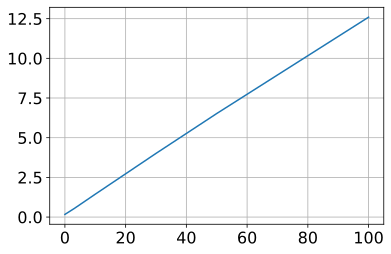

[0.16703188015479575,
 0.529528012092672,
 1.4412561903182293,
 4.011010995275974,
 6.524101562290968,
 12.59494786399624]

In [8]:
kNLs = [(np.trapz(PLindata[:,i],kPLin)/6/np.pi**2)**-.5 for i in range(len(zs))]
plt.plot(zs,kNLs)
plt.grid()
# plt.xlim(0,6)
# plt.ylim(0,1)
plt.show()
kNLs

# First we calculate the Gaussian Fisher $F^G_{ab}$

In [47]:
def GaussIntegrand(k,kmin,kmax,TFint,PNonLinInt,BShape,BShape2):
    result = np.zeros((len(k)))

    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    theta = k[:,2]

    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    dVol = 2*np.pi * 4*np.pi * k1**2 * k2**2 * (kmax-kmin) * (kmax-kmin) * np.sin(theta)

    TF1 = TFint(k1)
    TF2 = TFint(k2)
    TF3 = TFint(k3)
    
    P1prim = P(k1*h)
    P2prim = P(k2*h)
    P3prim = P(k3*h)
    
    P1 = h**3 * TF1**2 * P1prim
    P2 = h**3 * TF2**2 * P2prim
    P3 = h**3 * TF3**2 * P3prim
    
    bools = k1 < kmin
    bools+= k2 < kmin
    bools+= k3 < kmin
    
    bools+= k1 > kmax
    bools+= k2 > kmax
    bools+= k3 > kmax

    W1 = h**6 *TF1*TF2*TF3*BShape(P1prim,P2prim,P3prim)/6/P1/P2/P3
    if BShape2 == None:
        W2 = W1
    else:
        W2 = h**6 * TF1*TF2*TF3*BShape2(P1prim,P2prim,P3prim)/6/P1/P2/P3

    result = W1*W2 * 6 * P1 * P2 * P3 / (2*np.pi)**3 / kF**3
    result[bools] = 0
    result *= dVol
    
    return result

def Gauss(kmin,kmax,zn,BShape,BShape2=None,rtol=1e-3,verbose=0):
    z = zs[zn]
    TFint = interpolate(kh_transfer,Tc[:,zn])
    PNonLinInt = interpolate(kPNonLin,PNonLindata[:,zn])
    
#     print("z",zn,zs[zn])

    @vegas.batchintegrand
    def integrandbatch(k):
        return GaussIntegrand(k,kmin,kmax,TFint,PNonLinInt,BShape,BShape2)

    integ = vegas.Integrator([[0,1],[0,1],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zn,zs[zn])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zn, Q, mean, rerr

%time Gauss(kF,kNLs[0],0,BLocal,rtol=1e-3,verbose=1)

z 0 0
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0012984(75)   0.0012984(75)       0.00     1.00
  2   0.0012972(13)   0.0012972(13)       0.02     0.88
  3   0.0012985(11)   0.00129797(86)      0.27     0.76

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0012998(11)   0.0012998(11)       0.00     1.00

CPU times: user 165 ms, sys: 21 ms, total: 186 ms
Wall time: 189 ms


(0, nan, 0.0012998411543990022, 0.0008201244171370194)

# Then we compute the non-Gaussian contribution to $F_{ab}^{NG}$ from the P*T

In [10]:
def NonGaussIntegrandT(k,kmin,kmax,TFint,BShape):
    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    phik2 = k[:,2]
    thetak2 = k[:,3]
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(thetak2))
    q1 = k1
    q2 = kmin + k[:,4] * (kmax-kmin)
    phiq2 = k[:,5]
    thetaq2 = k[:,6]
    q3 = np.sqrt(k1**2 + q2**2 - 2*k1*q2*np.cos(thetaq2))
    K12 = k1
    K13 = np.sqrt(k2**2 + q2**2 + 2*k2*q2*(np.cos(thetak2)*np.cos(thetaq2) + np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    K14 = np.sqrt(k1**2 + k2**2 + q2**2 + 2*k2*np.cos(thetak2)*(k1 - q2*np.cos(thetaq2)) - 2*q2*(k1*np.cos(thetaq2) + k2*np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    
    #4pi comes from integrating out the k1 angles
    #2*2 from symmetry that allows to half the polar angles of k2 and q2
    dVol = 2*2 * 4*np.pi * k1**2 * k2**2 * q2**2 * (kmax-kmin) * (kmax-kmin)* (kmax-kmin) * np.sin(thetak2) * np.sin(thetaq2)
    
    bools = k1 < kmin
    bools+= k2 < kmin
    bools+= k3 < kmin
    bools+= q1 < kmin
    bools+= q2 < kmin
    bools+= q3 < kmin
    bools+= K12< kmin
    bools+= K13< kmin
    bools+= K14< kmin
    bools+= k1 > kmax
    bools+= k2 > kmax
    bools+= k3 > kmax
    bools+= q1 > kmax
    bools+= q2 > kmax
    bools+= q3 > kmax
    bools+= K12> 2*kmax
    bools+= K13> 2*kmax
    bools+= K14> 2*kmax 

    TFk1 = TFint(k1)
    TFk2 = TFint(k2)
    TFk3 = TFint(k3)
    TFq1 = TFint(q1)
    TFq2 = TFint(q2)
    TFq3 = TFint(q3)
    TF12 = TFint(K12)
    TF13 = TFint(K13)
    TF14 = TFint(K14)
    
    Pk1prim = P(k1*h)
    Pk2prim = P(k2*h)
    Pk3prim = P(k3*h)
    Pq1prim = P(q1*h)
    Pq2prim = P(q2*h)
    Pq3prim = P(q3*h)
    P12prim = P(K12*h)
    P13prim = P(K13*h)
    P14prim = P(K14*h)
    
    Pk1 = h**3 * TFk1**2 * Pk1prim
    Pk2 = h**3 * TFk2**2 * Pk2prim
    Pk3 = h**3 * TFk3**2 * Pk3prim
    Pq1 = h**3 * TFq1**2 * Pq1prim
    Pq2 = h**3 * TFq2**2 * Pq2prim
    Pq3 = h**3 * TFq3**2 * Pq3prim
    P12 = h**3 * TF12**2 * P12prim
    P13 = h**3 * TF13**2 * P13prim
    P14 = h**3 * TF14**2 * P14prim
    
    W1 = h**6 * TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/6/Pk1/Pk2/Pk3
    W2 = h**6 * TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/6/Pq1/Pq2/Pq3
    
    T = TSec(k2,k3,q2,q3,K12,K13,K14,Pk2,Pk3,Pq2,Pq3,P12,P13,P14) ## gives back all permutations already
    
    result = 9 * W1 * W2 * Pk1 * T / (2*np.pi)**6 / kF**3
    result[bools] = 0
    result *= dVol

    return result

def NonGaussT(kmin,kmax,zn,BShape,rtol=1e-3,verbose=0):
    z = zs[zn]
    TFint = interpolate(kh_transfer,Tc[:,zn])

    @vegas.batchintegrand
    def integrandbatch(k):
        return NonGaussIntegrandT(k,kmin,kmax,TFint,BShape)
    
    integ = vegas.Integrator([[0,1],[0,1],[0,np.pi],[0,np.pi],[0,1],[0,np.pi],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zn,zs[zn])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zn, Q, mean, rerr

%time NonGaussT(kF,kNLs[0],0,BLocal,rtol=1e-3,verbose=1)

z 0 0
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.009894(83)    0.009894(83)        0.00     1.00
  2   0.009949(35)    0.009941(32)        0.38     0.54
  3   0.009995(29)    0.009970(22)        0.97     0.38
  4   0.009995(27)    0.009980(17)        0.81     0.49
  5   0.009942(26)    0.009969(14)        0.99     0.41
  6   0.009979(25)    0.009971(12)        0.82     0.54
  7   0.010044(25)    0.009986(11)        1.84     0.09
  8   0.009975(25)    0.009984(10)        1.59     0.13
  9   0.010007(24)    0.0099873(93)       1.49     0.15

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.009992(24)    0.009992(24)        0.00     1.00
  2   0.009954(23)    0.009972(17)        1.30     0.25
  3   0.009964(24)    0.009969(14)        0.69     0.50
  4   0.009953(23)    0.009965(12)        0.59     0.62
  5   0.009960(23)    0.009964(11)       

(0, 0.8725272776247008, 0.009964415175065832, 0.0009662159646811326)

## And compute the contribution 

In [11]:
def NonGaussIntegrandBB(k,kmin,kmax,TFint,PNonLinInt,BShape):
    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    phik2 = k[:,2]
    thetak2 = k[:,3]
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(thetak2))
    q1 = k3
    q2 = kmin + k[:,4] * (kmax-kmin)
    phiq2 = k[:,5]
    thetaq2 = k[:,6]
    q3 = np.sqrt(k1**2 + k2**2 + q2**2 + 2*k2*np.cos(thetak2)*(k1 - q2*np.cos(thetaq2)) - 2*q2*(k1*np.cos(thetaq2) + k2*np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    
    #4*pi comes from integrating out the k1 angles
    dVol = 4*np.pi * k1**2 * k2**2 * q2**2 * (kmax-kmin) * (kmax-kmin)* (kmax-kmin) * np.sin(thetak2) * np.sin(thetaq2)

    bools = k1 < kmin
    bools+= k2 < kmin
    bools+= k3 < kmin
    bools+= q1 < kmin
    bools+= q2 < kmin
    bools+= q3 < kmin
    bools+= k1 > kmax
    bools+= k2 > kmax
    bools+= k3 > kmax
    bools+= q1 > kmax
    bools+= q2 > kmax
    bools+= q3 > kmax

    TFk1 = TFint(k1)
    TFk2 = TFint(k2)
    TFk3 = TFint(k3)
    TFq1 = TFint(q1)
    TFq2 = TFint(q2)
    TFq3 = TFint(q3)
    
    Pk1prim = P(k1*h)
    Pk2prim = P(k2*h)
    Pk3prim = P(k3*h)
    Pq1prim = P(q1*h)
    Pq2prim = P(q2*h)
    Pq3prim = P(q3*h)
    
    Pk1 = h**3 * TFk1**2 * Pk1prim
    Pk2 = h**3 * TFk2**2 * Pk2prim
    Pk3 = h**3 * TFk3**2 * Pk3prim
    Pq1 = h**3 * TFq1**2 * Pq1prim
    Pq2 = h**3 * TFq2**2 * Pq2prim
    Pq3 = h**3 * TFq3**2 * Pq3prim
    
    W1 = h**6 * TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/6/Pk1/Pk2/Pk3
    W2 = h**6 * TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/6/Pq1/Pq2/Pq3
    
    BS1 = Pk1*Pk2*BSec(k1,k2,k3)+Pk1*Pk3*BSec(k1,k3,k2)+Pk2*Pk3*BSec(k2,k3,k1)
    BS2 = Pq1*Pq2*BSec(q1,q2,q3)+Pq1*Pq3*BSec(q1,q3,q2)+Pq2*Pq3*BSec(q2,q3,q1)
    
    result = 9*W1*W2*BS1*BS2 / (2*np.pi)**6 / kF**3
    result[bools] = 0
    result *= dVol
    
    return result

def NonGaussBB(kmin,kmax,zn,BShape,rtol=1e-3,verbose=0):
    z = zs[zn]
    TFint = interpolate(kh_transfer,Tc[:,zn])
    PNonLinInt = interpolate(kPNonLin,PNonLindata[:,zn])


    @vegas.batchintegrand
    def integrandbatch(k):
        return NonGaussIntegrandBB(k,kmin,kmax,TFint,PNonLinInt,BShape)

    integ = vegas.Integrator([[0,1],[0,1],[0,2*np.pi],[0,np.pi],[0,1],[0,2*np.pi],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zn,zs[zn])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zn, Q, mean, rerr

%time NonGaussBB(kF,kNLs[0],0,BLocal,rtol=1e-3,verbose=1)

z 0 0
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.00739(29)     0.00739(29)         0.00     1.00
  2   0.007941(93)    0.007888(89)        3.32     0.07
  3   0.007739(47)    0.007772(41)        2.77     0.06
  4   0.007859(43)    0.007814(30)        2.55     0.05
  5   0.007766(39)    0.007796(24)        2.15     0.07
  6   0.007888(42)    0.007818(21)        2.44     0.03
  7   0.007818(37)    0.007818(18)        2.03     0.06
  8   0.007822(38)    0.007819(16)        1.74     0.09
  9   0.007811(34)    0.007817(15)        1.53     0.14
 10   0.007854(38)    0.007822(14)        1.46     0.16

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.007857(36)    0.007857(36)        0.00     1.00
  2   0.007835(35)    0.007846(25)        0.19     0.66
  3   0.007801(35)    0.007830(20)        0.63     0.53
  4   0.007838(35)    0.007832(18)       

(0, 0.8178178811890502, 0.007829557798403691, 0.0009782980347860576)

## Now compute the fishers, for the different primordial bispectra

In [12]:
kmin = kF
kmaxlow = kmin*1.1
kmaxhigh = kNLs

# print(kmin,kmaxlow,kmaxhigh)

zns = [0,1,2,3,4,5]

kmaxs = np.logspace(np.log10(kmaxlow),np.log10(kmaxhigh),16)
BShapes = [BLocal,BEquil,BOrtho]
ShapeLabels=["Local","Equil","Ortho"]

tasks = [delayed(Gauss)(kmin,kmax,zi,BS,rtol=0.01) for BS in BShapes for zi in zns for kmax in kmaxs[:,zi]]
GaussDat = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))

tasks = [delayed(NonGaussT)(kmin,kmax,zi,BS,rtol=0.01) for BS in BShapes for zi in zns for kmax in kmaxs[:,zi]]
NonGaussTDat = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))

tasks = [delayed(NonGaussBB)(kmin,kmax,zi,BS,rtol=0.01) for BS in BShapes for zi in zns for kmax in kmaxs[:,zi]]
NonGaussBDat = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))

Gaussian = np.zeros((len(BShapes),len(zns),len(kmaxs)))
NonGaussianT = np.zeros((len(BShapes),len(zns),len(kmaxs)))
NonGaussianB = np.zeros((len(BShapes),len(zns),len(kmaxs)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   49.4s finished


## The Fisher is then approximated by $$F_{ab} = \frac{\left(F^G_{ab}\right)^2}{F_{ab}^G+F_{ab}^{NG}}$$

In [13]:
Gaussian = GaussDat[:,-2].reshape((len(BShapes),len(zns),len(kmaxs)))
NonGaussianT = NonGaussTDat[:,-2].reshape((len(BShapes),len(zns),len(kmaxs)))
NonGaussianB = NonGaussBDat[:,-2].reshape((len(BShapes),len(zns),len(kmaxs)))

SN2G = Gaussian
SN2NG= Gaussian**2 / (Gaussian + NonGaussianB + NonGaussianT)

## Plot the uncertainty $$ \sigma_{f_{NL}} = F_{f_{NL}f_{NL}}^{-1/2}$$

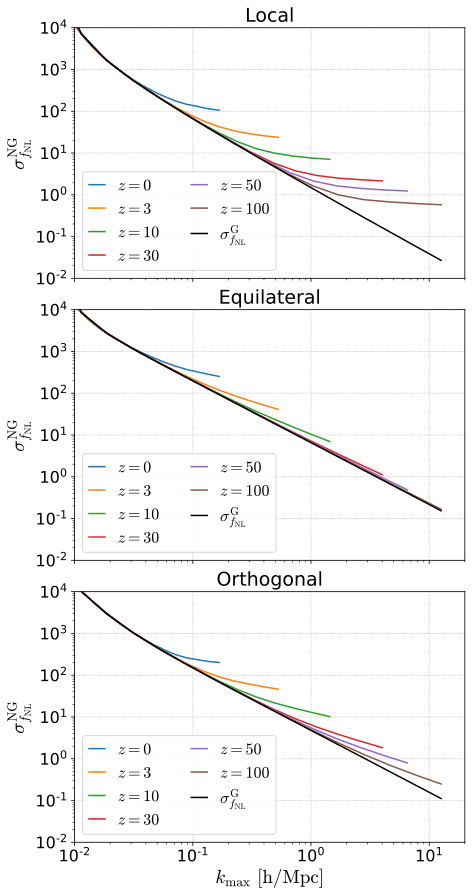

In [38]:
fig, axs = plt.subplots(3,1,sharex=True,figsize=(7,15))
plt.subplots_adjust(wspace=0, hspace=0.125)

ShapeLabels=["Local","Equilateral","Orthogonal"]

for si in range(len(BShapes)):
        
    plt.gca().set_prop_cycle(None)
        
    [axs[si].loglog(kmaxs[:,zi], SN2NG[si,zi]**-.5) for zi in range(len(zns))] #Both P*T and B*B
    axs[si].loglog(kmaxs[:,-1], SN2G[si,-1]**-.5,"-k")
    axs[si].set_ylabel("$\sigma^{\\rm NG}_{f_{\\rm NL}}$",fontsize=19)

    axs[si].grid(linestyle=":")
    plt.xlim(1e-2,2e1)
    labels = np.array(["$z=$" + f"${zs[zi]}$" for zi in zns])
    labels = np.append(labels,["$\sigma^{\\rm G}_{f_{\\rm NL}}$"])
    
#     plt.legend(labels,title=ShapeLabels[si])
    axs[si].legend(labels,loc=3,ncol=2,handlelength=1,fontsize=16)
    axs[si].set_ylim(1e-2,1e4)
    axs[si].set_title(str(ShapeLabels[si]),fontsize=19)
#     plt.title(ShapeLabels[si])
plt.xlabel("$k_{\\rm max}$ $\\rm [h/Mpc]$",fontsize=19)

plt.savefig(f"Results/Error_BS.pdf",format='pdf',bbox_inches='tight')
plt.show()